In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np

import gseapy

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from upsetplot import from_contents, UpSet

from scipy.spatial.distance import pdist, squareform
from scipy.stats import chisquare, norm
import scipy.sparse as sp

from statsmodels.stats.multitest import multipletests

import scvelo
from sklearn.decomposition import NMF
from sklearn.preprocessing import minmax_scale

import pickle


In [ ]:

import sys
sys.path.append("..")

from SIGMOD import SIGMOD_SVLR as svlr

In [3]:
sc.set_figure_params(vector_friendly=True, dpi_save=300) 
sns.set_theme(style="white") 
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams.update({
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

## SVLR on all slides

In [18]:
sample_name = ["C1","C2","C3","C4","L1","L2"]
prefix = ["GSM7058756_C1","GSM7058757_C2","GSM7058758_C3","GSM7058759_C4","GSM7058760_L1","GSM7058761_L2"]

In [21]:
for i in range(6):
    # File name
    mtx_file = "/home/liuchang/4.0_Resource/2.0_scRNA/1.0_Cancer/1.0_COAD/GSE225857/Data/" + sample_name[i] + "/"
    pos_file = "/home/liuchang/4.0_Resource/2.0_scRNA/1.0_Cancer/1.0_COAD/GSE225857/Data/" + sample_name[i] + "/" + prefix[i] + "_tissue_positions_list.csv.gz"
    output_file = "Results/SVLR/" + sample_name[i] + "_lr_res.csv"
    # Read ST data and spatial dataframe
    adata_vis = sc.read_10x_mtx(mtx_file,prefix = prefix[i] + ".")

    spatial_df = pd.read_csv(pos_file,
                            compression='gzip',
                            header=None)
    spatial_df = spatial_df.set_index(0)
    spatial_df_ = spatial_df.loc[list(adata_vis.obs.index),:]

    adata_vis.obs["x"] = spatial_df_.iloc[:,1]
    adata_vis.obs["y"] = spatial_df_.iloc[:,2]

    adata_vis.var_names_make_unique() 

    sc.pp.filter_genes(adata_vis, min_cells=adata_vis.obs.shape[0]*0.005)
    sc.pp.normalize_total(adata_vis, target_sum=1e4)
    sc.pp.log1p(adata_vis)

    # read LR database
    lr_df = pd.read_csv("/home/liuchang/4.0_Resource/lr/human_lr_pair.txt",sep="\t")
    lr_df = lr_df[(lr_df['ligand_gene_symbol'].isin(adata_vis.var_names)) & 
                (lr_df['receptor_gene_symbol'].isin(adata_vis.var_names))]

    ligand = [ pd.Series(i).values for i in lr_df.ligand_gene_symbol.values]
    receptor = [ pd.Series(i).values for i in lr_df.receptor_gene_symbol.values]

    # create spot-spot distance graph
    layer = adata_vis.obs
    KNN_df=svlr.get_KNN_graph(layer,2,)
    cells = np.array(adata_vis.obs_names)
    cells_id_tran = dict(zip(cells, range(cells.shape[0])))
    KNN_df['Cell1_ID'] = KNN_df['Cell1'].map(cells_id_tran)
    KNN_df['Cell2_ID'] = KNN_df['Cell2'].map(cells_id_tran)
    layer["cell_order"] =  layer.index.map(cells_id_tran)

    # create sliding window
    n = 3 
    mx = 5
    my = 5
    x_range = [layer['x'].min(), layer['x'].max()]
    y_range = [layer['y'].min(), layer['y'].max()]
    x_step = (x_range[1] - x_range[0] - mx * (n - 1)) / n
    y_step = (y_range[1] - y_range[0] - my * (n - 1)) / n
    subspaces = svlr.create_subspaces(layer, n, x_range, y_range, x_step, y_step, mx, my)
    selected_subspaces = {key: val for key, val in subspaces.items() if len(val) > 10}

    G_df = KNN_df.copy()
    dist_mat = sp.coo_matrix((G_df['Distance'], 
                              (G_df['Cell1_ID'], G_df['Cell2_ID'])), 
                             shape=(adata_vis.n_obs,adata_vis.n_obs))
    dist_mat = dist_mat + sp.eye(dist_mat.shape[0])
    dist_mat = dist_mat.toarray()

    # run SVLR
    lr_res,lr_pair,ligands,receptors = svlr.run_svlr(ligand,
                                receptor,
                                dist_mat,
                                selected_subspaces,
                                adata_vis)

    # Convert results to DataFrame
    lr_res_df = pd.DataFrame(lr_res, columns=list(selected_subspaces.keys())+['density_p', 'L_R_mean_strength', 'L_R_mean_z'])
    lr_res_df.index = lr_pair
    lr_res_df['ligands'] = ligands
    lr_res_df['receptors'] = receptors
    lr_res_df.index = lr_pair
    lr_res_df = lr_res_df.fillna(1)
    lr_res_df['mean_p'] = lr_res_df['L_R_mean_z'].apply(lambda z: 1 - norm.cdf(z) if z > 0 else norm.cdf(z)) # 基于标准正态分布计算互作强度的p值
    # Apply Bonferroni correction for multiple testing on p-values and chi.p-values
    lr_res_df['mean_fdr'] = multipletests(lr_res_df['mean_p'], method='bonferroni')[1]
    lr_res_df['density_fdr'] = multipletests(lr_res_df['density_p'], method='bonferroni')[1]
    lr_res_df['mean_fdr_log'] = -np.log10(lr_res_df['mean_fdr'])
    lr_res_df['density_fdr_log'] = -np.log10(lr_res_df['density_fdr'])
    lr_res_df['density_p_log'] = -np.log10(lr_res_df['density_p'])
    lr_res_df.to_csv(output_file,index=True,header=True)

Only considering the two last: ['.mtx', '.gz'].
Only considering the two last: ['.mtx', '.gz'].
mean spots in each subspaces is:  227


  0%|          | 0/2240 [00:00<?, ?it/s]

Only considering the two last: ['.mtx', '.gz'].
Only considering the two last: ['.mtx', '.gz'].
mean spots in each subspaces is:  367


  0%|          | 0/2144 [00:00<?, ?it/s]

Only considering the two last: ['.mtx', '.gz'].
Only considering the two last: ['.mtx', '.gz'].
mean spots in each subspaces is:  386


  0%|          | 0/1882 [00:00<?, ?it/s]

Only considering the two last: ['.mtx', '.gz'].
Only considering the two last: ['.mtx', '.gz'].
mean spots in each subspaces is:  468


  0%|          | 0/1657 [00:00<?, ?it/s]

Only considering the two last: ['.mtx', '.gz'].
Only considering the two last: ['.mtx', '.gz'].
mean spots in each subspaces is:  527


  0%|          | 0/1914 [00:00<?, ?it/s]

Only considering the two last: ['.mtx', '.gz'].
Only considering the two last: ['.mtx', '.gz'].
mean spots in each subspaces is:  541


  0%|          | 0/1246 [00:00<?, ?it/s]

### Combined SVLR analysis

In [4]:
lr_df = pd.read_csv("/home/liuchang/4.0_Resource/lr/human_lr_pair.txt",sep="\t")

l_secrete = 6/2
l_contact = 2/3

In [5]:
sample_name = ["C1","C2","C3","C4","L1","L2"]
prefix = ["GSM7058756_C1","GSM7058757_C2","GSM7058758_C3","GSM7058759_C4","GSM7058760_L1","GSM7058761_L2"]


adata_list = []
lr_res_list = []

In [8]:
for i in range(6):

    mtx_file = "/home/liuchang/4.0_Resource/2.0_scRNA/1.0_Cancer/1.0_COAD/GSE225857/Data/" + sample_name[i] + "/"
    pos_file = "/home/liuchang/4.0_Resource/2.0_scRNA/1.0_Cancer/1.0_COAD/GSE225857/Data/" + sample_name[i] + "/" + prefix[i] + "_tissue_positions_list.csv.gz"

    tmp = sc.read_10x_mtx(mtx_file,prefix = prefix[i] + ".")
    
    spatial_df = pd.read_csv(pos_file,
                             compression='gzip',
                             header=None)
    spatial_df = spatial_df.set_index(0)
    spatial_df_ = spatial_df.loc[list(tmp.obs.index),:]
    
    tmp.obs["x"] = spatial_df_.iloc[:,1]
    tmp.obs["y"] = spatial_df_.iloc[:,2]
    
    tmp.var_names_make_unique() 
    tmp.raw = tmp.copy()
    
    sc.pp.normalize_total(tmp, target_sum=1e4)
    sc.pp.log1p(tmp)

    tmp.obs.index = [sample_name[i] + "_" + cell_name for cell_name in tmp.obs.index]

    lr_file = "Results/SVLR/" + sample_name[i] + "_lr_res.csv"
    lr_res_df = pd.read_csv(lr_file,index_col=0)
    
    lr_res_df_0_05 = lr_res_df[(lr_res_df['mean_fdr'] < 0.05) & (lr_res_df['L_R_mean_strength'] > 1) & (lr_res_df['density_fdr'] < 0.05)]
    
    lr_res_df_0_05['annotation'] = 'Secreted Signaling' # For cell talk db
    
    adata_list.append(tmp)
    lr_res_list.append(list(lr_res_df_0_05.index))

Only considering the two last: ['.mtx', '.gz'].
Only considering the two last: ['.mtx', '.gz'].
Only considering the two last: ['.mtx', '.gz'].
Only considering the two last: ['.mtx', '.gz'].
Only considering the two last: ['.mtx', '.gz'].
Only considering the two last: ['.mtx', '.gz'].
Only considering the two last: ['.mtx', '.gz'].
Only considering the two last: ['.mtx', '.gz'].
Only considering the two last: ['.mtx', '.gz'].
Only considering the two last: ['.mtx', '.gz'].
Only considering the two last: ['.mtx', '.gz'].
Only considering the two last: ['.mtx', '.gz'].


In [9]:
lr_df_list = []

for sublist in lr_res_list:
    data = [item.split('_') for item in sublist]
    df = pd.DataFrame(data, columns=['ligands', 'receptors'])
    df['annotation'] = 'Secreted Signaling'
    df['lr'] = sublist
    lr_df_list.append(df)

In [10]:
niche_res_list = []
for adata,lr_df in zip(adata_list,lr_df_list):
    
    pos = adata.obs.loc[:,["x","y"]]
    
    niche_res,secrete_index,contact_index = svlr.Create_Niche(adata,
                                                              pos,
                                                              l_secrete,
                                                              l_contact,
                                                              lr_df)
    niche_res_df = pd.concat(niche_res,axis=1)
    niche_res_df.columns = secrete_index.append(contact_index)
    niche_res_df.index = pos.index
    
    niche_res_list.append(niche_res_df)

  0%|          | 0/585 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/668 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/489 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/348 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/583 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [11]:
niche_res_list_columns = []
for niche_res_df,lr_df in zip(niche_res_list,lr_df_list):

    niche_res_df.columns = lr_df["lr"]
    niche_res_list_columns.append(niche_res_df)

In [ ]:
# with open('./Results/SVLR/preprocess_all_SVLR.pickle', 'wb') as f:
#     pickle.dump(adata_list, f)
#     pickle.dump(niche_res_list, f)

In [16]:
scaled_lr_res_list = svlr.process_niche_res_list(niche_res_list)

Processing DataFrames:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
# with open('./Results/SVLR/scaled_lr_res_list_SVLR.pickle', 'wb') as f:
#     pickle.dump(scaled_lr_res_list, f)

In [3]:
with open('./Results/SVLR/preprocess_all_SVLR.pickle', 'rb') as f:
    adata_list = pickle.load(f)
    niche_res_list = pickle.load(f)

/miniconda3/lib/python3.10/site-packages/setuptools_scm/_integration/setuptools.py:30: RuntimeWarning: 
ERROR: setuptools==60.2.0 is used in combination with setuptools_scm>=8.x

Your build configuration is incomplete and previously worked by accident!
setuptools_scm requires setuptools>=61

Suggested workaround if applicable:
 - migrating from the deprecated setup_requires mechanism to pep517/518
   and using a pyproject.toml to declare build dependencies
   which are reliably pre-installed before running the build tools

  warnings.warn(


In [6]:
with open('./Results/SVLR/scaled_lr_res_list_SVLR.pickle', 'rb') as f:
    scaled_lr_res_list = pickle.load(f)

In [7]:
merged_lr_df = pd.concat(scaled_lr_res_list, axis=0, join='outer', sort=False)
merged_lr_df = merged_lr_df.fillna(0)

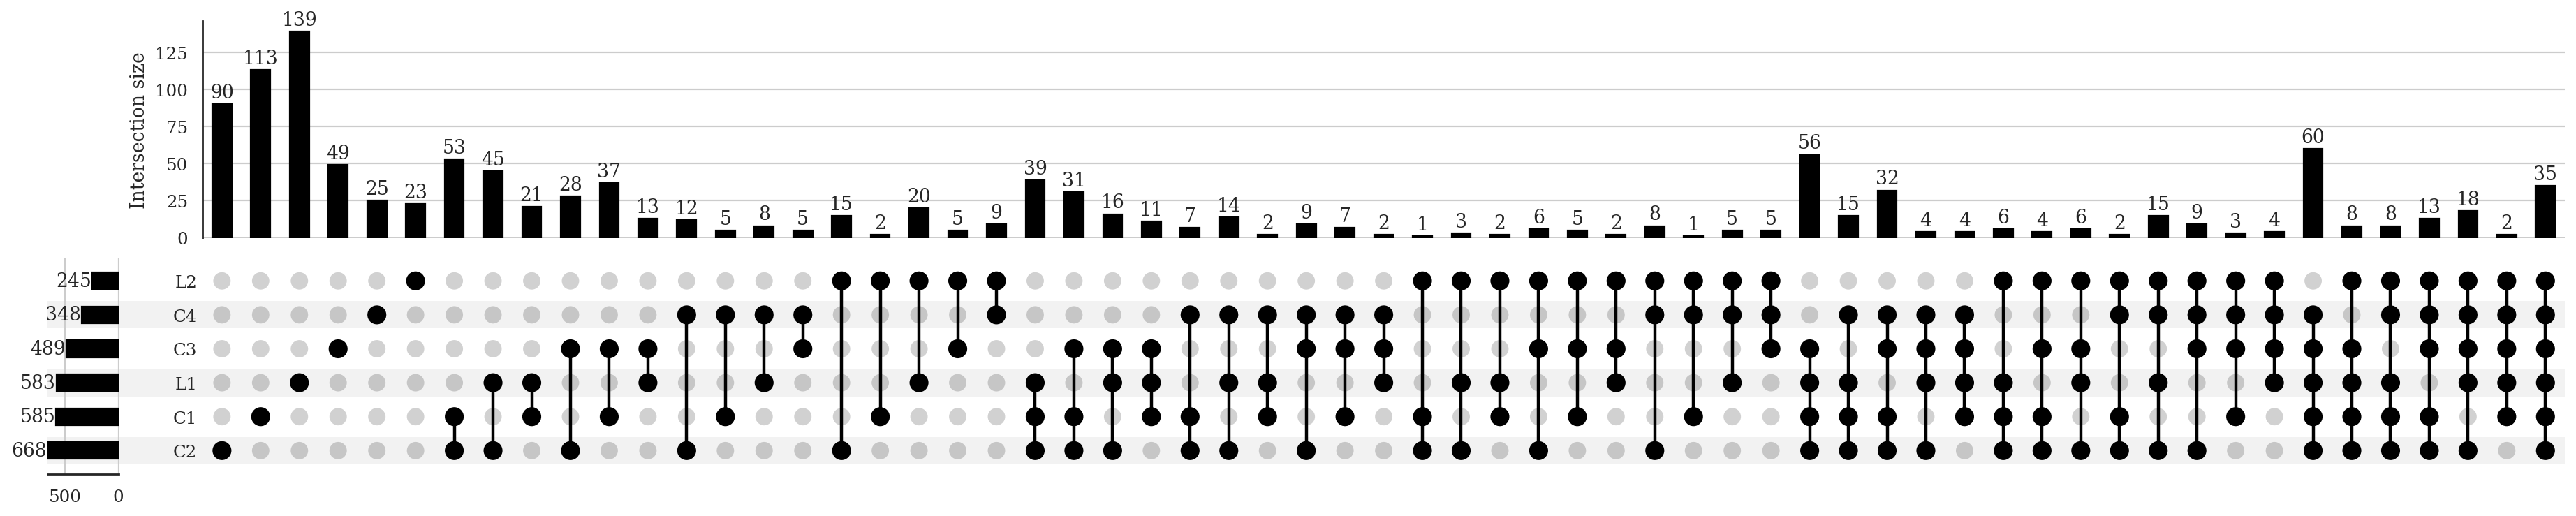

In [13]:
### Upset Plot
data = from_contents({
    'C1': list(scaled_lr_res_list[0].columns),
    'C2': list(scaled_lr_res_list[1].columns),
    'C3': list(scaled_lr_res_list[2].columns),
    'C4': list(scaled_lr_res_list[3].columns),
    'L1': list(scaled_lr_res_list[4].columns),
    'L2': list(scaled_lr_res_list[5].columns)
})
UpSet(data, show_counts=True).plot()
plt.savefig("Figure/1_SVLR_upset.pdf")  
plt.show()

2025-05-13 08:33:38.875636: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-13 08:33:39.562282: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


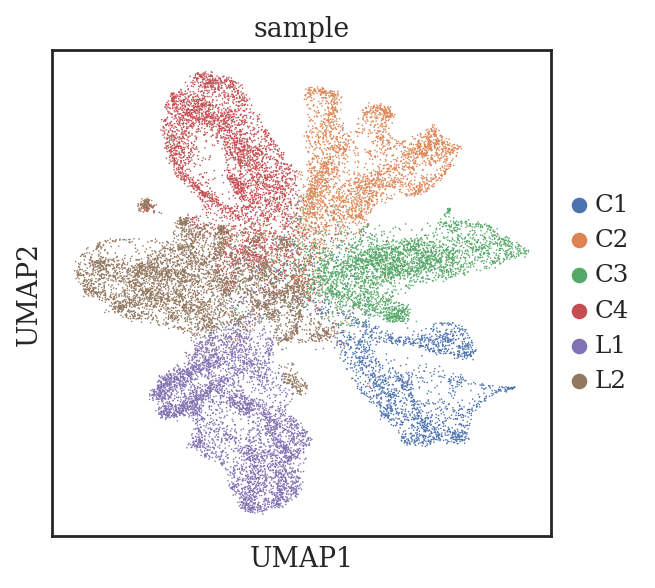

In [31]:
adata_tmp = sc.AnnData(merged_lr_df)
adata_tmp.obs["sample"] = adata_tmp.obs.index.str.split('_').str[0]
sc.tl.pca(adata_tmp)
sc.pp.neighbors(adata_tmp)
sc.tl.umap(adata_tmp)
sc.pl.umap(
    adata_tmp,
    color="sample",
    size=2,
)

In [14]:
%%time
model = NMF(n_components=15, init='random', random_state=0)
A_ = model.fit_transform(merged_lr_df)
B_ = model.components_

CPU times: user 54.7 s, sys: 58.8 s, total: 1min 53s
Wall time: 5.82 s


In [15]:
A_df = pd.DataFrame(A_,columns=["Niche" + str(i+1) for i in range(15)], index=merged_lr_df.index)
B_df = pd.DataFrame(B_,index = ["Niche"+ str(i+1) for i in range(15)], columns = merged_lr_df.columns)
B_df = B_df.T

In [20]:
adata_tmp = sc.AnnData(A_df)
adata_tmp.obs["sample"] = adata_tmp.obs.index.str.split('_').str[0]
sc.pp.neighbors(adata_tmp)
sc.tl.umap(adata_tmp)

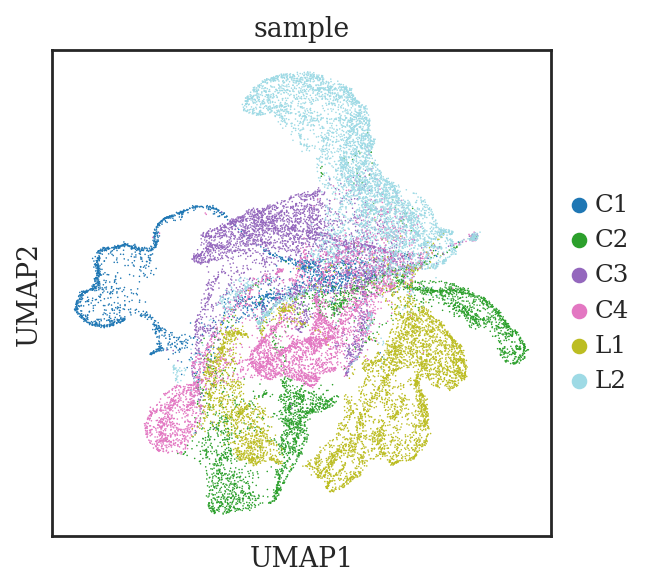

In [25]:
with plt.rc_context({'figure.figsize':(4,4)}):
    sc.pl.umap(
        adata_tmp,
        color="sample",
        size=2,
        palette="tab20",
        show = False,
    )
    plt.savefig("Figure/2_umap_nmf.pdf",bbox_inches = "tight")

In [26]:
adata=sc.concat(adata_list,merge='same')
adata.obs['sample'] = adata.obs.index.str.split('_').str[0]

In [28]:
adata.write_h5ad("./Data/adata_all_st.h5ad")

In [29]:
pos = adata.obs[["x","y","sample"]]
pos["cluster_id"] = A_df[['Niche'+str(i+1) for i in range(15)]].idxmax(axis=1)
pos.cluster_id.value_counts()

cluster_id
Niche15    3787
Niche2     2763
Niche14    2152
Niche6     1798
Niche1     1676
Niche3     1611
Niche9     1381
Niche8     1304
Niche12    1223
Niche7      959
Niche4      950
Niche13     822
Niche11     811
Niche5      592
Niche10     431
Name: count, dtype: int64

In [7]:
palette=["#00BFFF", "#6A3D9A", "#B3E2CD", "#E6AB02", "#48D1CC", ##1-5
         "#F4CAE4", "#EE82EE", "#FDCDAC", "#99CCCC", "#ABD9E9", ##6-10
         "#1A9850", "#9933CC", "#B3EE3A", "#87CEFA", "#E08214", ##11-15
         "#9970AB", "#DE77AE", "#F1E2CC", "#B3CDE3", "#FFFF99", ##16-20
         "#66C2A5", "#FF00CC", "#276419", "#CC99FF"] # 21-24

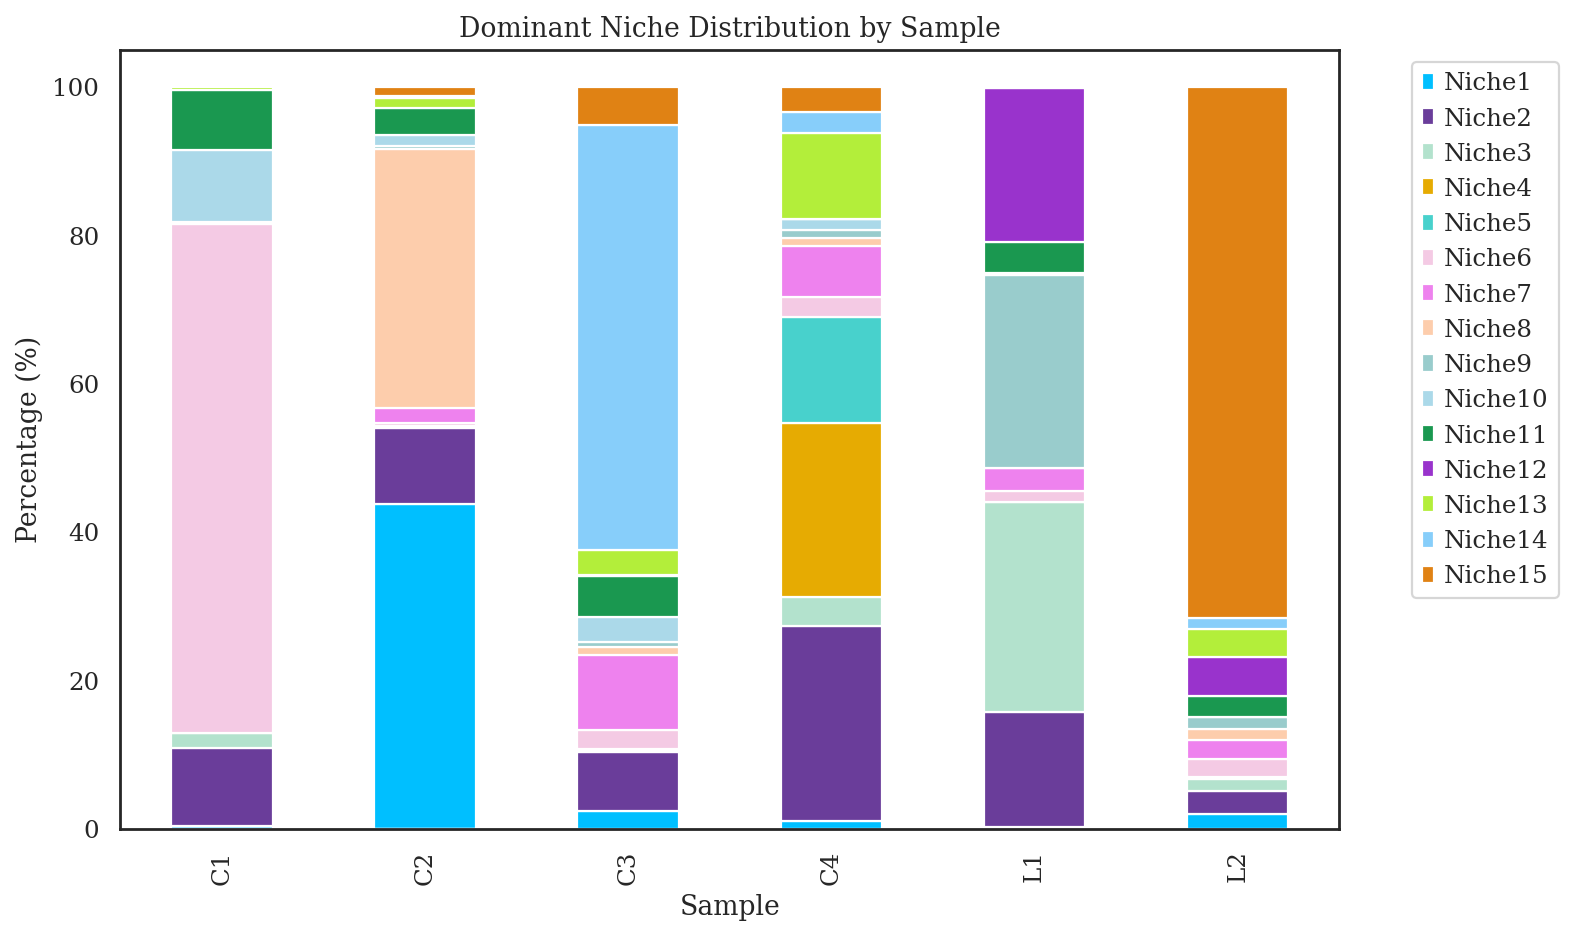

In [32]:
pos['cluster_id'] = pd.Categorical(pos['cluster_id'], categories=['Niche'+str(i+1) for i in range(15)], ordered=True)
dominant_counts = pos.groupby(['sample', 'cluster_id']).size().unstack(fill_value=0)

dominant_percentage = dominant_counts.div(dominant_counts.sum(axis=1), axis=0) * 100

ax = dominant_percentage.plot(kind='bar', stacked=True, figsize=(10, 6),color=palette)

plt.title('Dominant Niche Distribution by Sample')
plt.xlabel('Sample')
plt.ylabel('Percentage (%)')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('Figure/2_2_Dominant_Niche_barplot.pdf')
plt.show()

In [36]:
A_df.to_csv("Results/SVLR/niche_res_topic15.csv",index=True)
B_df.to_csv("Results/SVLR/lr_niche_topic15.csv",index=True)